# Example 5.12 (A control ellipse for future overtime hours)

In [1]:
import pathlib
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse

In [2]:
def load_data() -> pd.DataFrame:
    fpth = pathlib.Path(r'..\..\data\Table5.8.xlsx')
    return pd.read_excel(fpth)

In [3]:
df = load_data()

In [4]:
# X is n x p = 16 x 2.
X = df.iloc[:, 0:2].to_numpy()

# Remove observation 11.
X = np.delete(X, 10, axis=0)
n, p = X.shape

In [5]:
xbar = np.mean(X, axis=0).reshape(p, 1)
S = np.cov(X.T, ddof=1)

In [6]:
alpha = 0.05
crit = (((n-1)*p)/(n-p))*scipy.stats.chi2(df=p).ppf(q=1-alpha)

Compute $T^{2} = \frac{n}{n + 1} {\left(\textbf{x} - \bar{\textbf{x}}\right)}^{\prime} \textbf{S}^{-1} {\left(\textbf{x} - \bar{\textbf{x}}\right)}$

In [7]:
Sinv = np.linalg.inv(S)
stat_dist = lambda x: (n/(n + 1)) * (x.reshape(1,p) - xbar.T) @ Sinv @ (x.reshape(p,1) - xbar)
dist = np.array([stat_dist(X[i,:]).flatten() for i in range(X.shape[0])])

How many values are larger than $\frac{(n-1)p}{(n-p)} F_{p=2, n-p = 13}\left(0.05\right)$?

In [8]:
print(f'There are {(dist > crit).sum()} observations larger than {crit:.2f}.')

There are 0 observations larger than 12.90.


In [9]:
def plot_control_ellipse(df: pd.DataFrame, alpha: float):
    df = df.copy()
    xbar = np.mean(df, axis=0).to_numpy()
    n, p = df.shape
    S = np.cov(df.T)

    eigenvalues, eigenvectors = np.linalg.eig(S)
    max_idx, min_idx = np.argmax(eigenvalues), np.argmin(eigenvalues)
    lmbda1, lmbda2 = eigenvalues[max_idx], eigenvalues[min_idx]
    e1, e2 = eigenvectors[:, max_idx].copy(), eigenvectors[:, min_idx].copy()

    # Using (5-34) on page 249.
    const = (p*(n**2 - 1))/(n*(n-p))
    chi2_val = scipy.stats.f(dfn=p, dfd=n-p).ppf(1 - alpha)

    # Restrict major-axis eigenvector to Quadrants 1 and 2.
    if np.all(e1 < 0) | ((e1[0] > 0) & (e1[1] < 0)):
        e1 = e1*(-1)

    ell_width = np.sqrt(lmbda1)*np.sqrt(const*chi2_val)
    ell_height = np.sqrt(lmbda2)*np.sqrt(const*chi2_val)
    # Use adjacent angle for cos based on quadrant 1 or 2.
    ell_angle = np.arccos(e1[1] if e1[0] > 0 else e1[0])*(180/np.pi)

    plt.figure()
    ax = plt.gca()
    ellipse = Ellipse(xy=xbar,
                      width=2*ell_width,
                      height=2*ell_height,
                      angle=ell_angle,
                      fill=False)
    ax.add_patch(ellipse)
    for i in [-1, 1]:
        plt.quiver(xbar[0],
                xbar[1],
                e1[0] * ell_width * i,
                e1[1] * ell_width * i,
                angles='xy',
                scale_units='xy',
                scale=1
                )
        plt.quiver(xbar[0],
                xbar[1],
                e2[0] * ell_height * i,
                e2[1] * ell_height * i,
                angles='xy',
                scale_units='xy',
                scale=1)
    return plt, ax

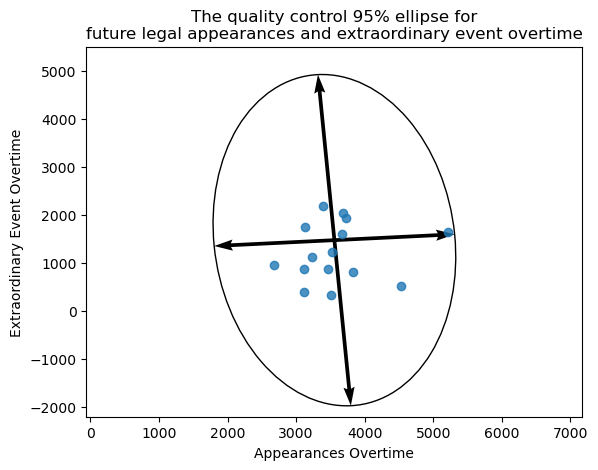

In [10]:
my_plot, ax = plot_control_ellipse(df.iloc[:,[0,1]], alpha)
my_plot.scatter(X[:,0], X[:,1], alpha=0.8)
my_plot.ylim([-2200, 5500])
ax.set_aspect(aspect=0.7, adjustable='datalim')
ax.set_title('The quality control 95% ellipse for\nfuture legal appearances and extraordinary event overtime')
my_plot.xlabel('Appearances Overtime')
my_plot.ylabel('Extraordinary Event Overtime')
plt.show()